<a href="https://colab.research.google.com/github/ddekun/Data_analysis_algorithms/blob/lesson8/hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Алгоритмы анализа данных

## Урок 8. Снижение размерности данных

### Домашнее задание

**1. Можно ли отобрать наиболее значимые признаки из имеющихся с помощью PCA? Ответ объясните.**

Да, но следует помнить, что PCA не выбирает из имеющихся признаков наиболее значимые, а строит новые, которые «учтут максимум информации» из имеющихся признаков, создав тем самым новое уменьшенное признаковое пространство.

**2. Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd(). Применить к данным на уроке и сравнить ответы.**

In [38]:
# Запишем в матрицу А характеристики Ирисов из набора данных
A = iris.data

In [33]:
# Проведём сингулярное разложение матрицы
U, s, W = np.linalg.svd(A)
V = W.T

In [39]:
def downgrade_svd(X, n_components):
    U, s, Vt = np.linalg.svd(X)
    V = Vt.T
    
    D = np.zeros_like(X, dtype=float)
    D[np.diag_indices(min(X.shape))] = s
    W = V[:, :n_components]
    
    return X.dot(W), s

In [40]:
AN, s = downgrade_svd(A, 3)

In [41]:
# Cингулярные числа, лежащие на главной диагонали матрицы 𝐷
s

array([95.95991387, 17.76103366,  3.46093093,  1.88482631])

In [43]:
iris_frame = pd.DataFrame(iris.data)
iris_frame.columns = iris.feature_names
iris_frame['target'] = iris.target
iris_frame['name'] = iris_frame.target.apply(lambda x : iris.target_names[x])
iris_frame.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [44]:
# DataFrame на основе матрицы AN
df_iris = pd.DataFrame(AN, columns=['f1','f2','f3'])
df_iris['target'] = iris_frame['target']
df_iris['name'] = iris_frame['name']
df_iris

,f1,f2,f3,target,name
0,-5.912747,2.302033,0.007402,0,setosa
1,-5.572482,1.971826,0.244592,0,setosa
2,-5.446977,2.095206,0.015029,0,setosa
3,-5.436459,1.870382,0.020505,0,setosa
4,-5.875645,2.328290,-0.110338,0,setosa
...,...,...,...,...,...
145,-9.226517,-0.931293,-0.204095,2,virginica
146,-8.566265,-1.039134,0.159305,2,virginica
147,-9.025923,-0.885027,-0.143421,2,virginica
148,-9.105599,-0.996416,-0.737103,2,virginica


In [45]:
feature_names = df_iris.columns[:-2]
class_column  = df_iris.columns[-2]
X = df_iris[feature_names]
y = df_iris[class_column]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns

In [55]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)

In [56]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

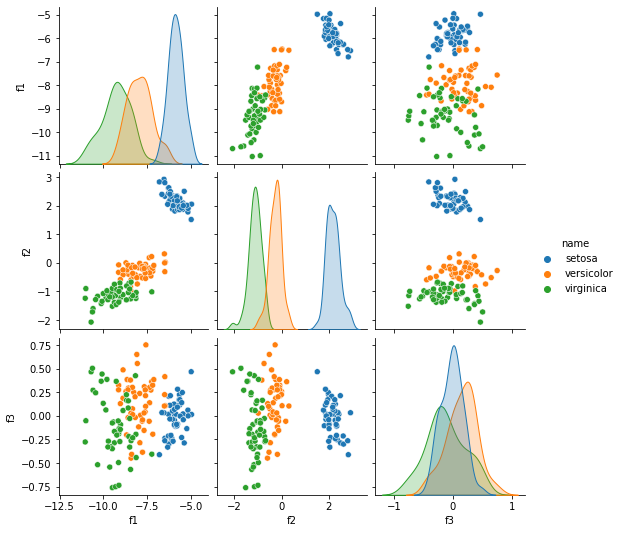

In [57]:
sns.pairplot(df_iris[['f1','f2','f3','name']], hue = 'name')

**3. Обучить любую модель классификации (из рассмотренных в курсе) на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.**

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

**Без PCA**

In [8]:
X, y = load_iris(return_X_y=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 4), (30, 4))

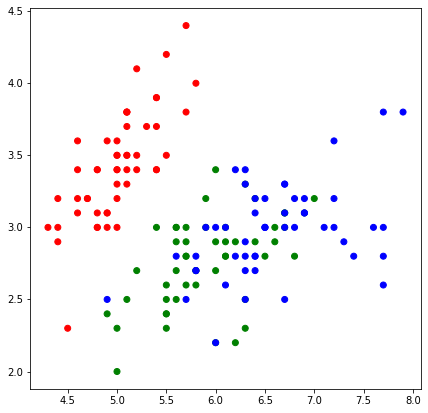

In [10]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [11]:
def e_metrics(x1, x2):

    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [12]:
def knn(x_train, y_train, x_test, k, weights=None):
    
    # расчет расстояний от классифицируемых объектов до
    # объектов обучающей выборки
    distances = np.sqrt(np.sum(np.square(x_test[:, np.newaxis] - x_train), axis=2))
                
    answers = []    
    for distance in distances:
        # Записываем в список значение расстояния и ответа на объекте обучающей выборки
        test_distances = [(dist, label) for dist, label in zip(distance, y_train)]
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for i, d in enumerate(sorted(test_distances)[0:k]):
            w = weights(i, d[0]) if weights else 1
            
            classes[d[1]] += w

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Напишем функцию для вычисления точности

In [13]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [14]:
k = 100

In [15]:
# Проверим работу алгоритма

y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма (без РСА) на трейне (без добавления весов для соседей) при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма (без РСА) на тесте (без добавления весов для соседей) при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма (без РСА) на трейне (без добавления весов для соседей) при k = 100: 0.500
Точность алгоритма (без РСА) на тесте (без добавления весов для соседей) при k = 100: 0.467


In [16]:
def weights_n_neighbor(i, d):
    return 1 / (d + 0.1)

In [17]:
y_pred_train = knn(X_train, y_train, X_train, k, weights_n_neighbor)
y_pred = knn(X_train, y_train, X_test, k, weights_n_neighbor)

print(f'Точность алгоритма (без РСА) на трейне при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма (без РСА) на тесте при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма (без РСА) на трейне при k = 100: 1.000
Точность алгоритма (без РСА) на тесте при k = 100: 0.967


**C PCA**

In [18]:
X, y = load_iris(return_X_y=True)

In [19]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [20]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [21]:
# Для начала отмасштабируем выборку
X = X.astype(float)

X = standard_scale(X)

In [22]:
X[:10]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ],
       [-0.53717756,  1.93979142, -1.16971425, -1.05217993],
       [-1.50652052,  0.78880759, -1.34022653, -1.18381211],
       [-1.02184904,  0.78880759, -1.2833891 , -1.3154443 ],
       [-1.74885626, -0.36217625, -1.34022653, -1.3154443 ],
       [-1.14301691,  0.09821729, -1.2833891 , -1.44707648]])

In [23]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X.T @ X

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(437.77467247979934, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021043, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.01353133569724, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.107225464292861, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


Оценим долю дисперсии, которая описывается найденными компонентами.

In [24]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.9624454132999, 22.850761786701742, 3.6689218892828745, 0.517870910715477]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [25]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [26]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)
Z[:10]

array([[-2.26470281, -0.4800266 ],
       [-2.08096115,  0.67413356],
       [-2.36422905,  0.34190802],
       [-2.29938422,  0.59739451],
       [-2.38984217, -0.64683538],
       [-2.07563095, -1.48917752],
       [-2.44402884, -0.0476442 ],
       [-2.23284716, -0.22314807],
       [-2.33464048,  1.11532768],
       [-2.18432817,  0.46901356]])

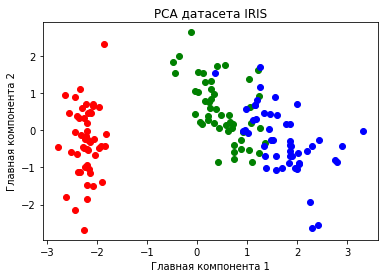

In [27]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

Таким образом, мы перешли от четырехмерного пространства признаков к двумерному и при этом классы остались разделимы в пространстве, то есть классификация возможна.

Разделим выборку на обучающую и тестовую

In [28]:
X_train, X_test, y_train, y_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 2), (30, 2))

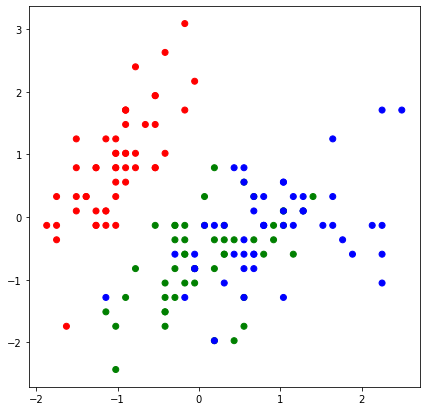

In [29]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [30]:
# Проверим работу алгоритма

y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма (c РСА) на трейне (без добавления весов для соседей) при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма (c РСА) на тесте (без добавления весов для соседей) при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма (c РСА) на трейне (без добавления весов для соседей) при k = 100: 0.675
Точность алгоритма (c РСА) на тесте (без добавления весов для соседей) при k = 100: 0.567


In [31]:
y_pred_train = knn(X_train, y_train, X_train, k, weights_n_neighbor)
y_pred = knn(X_train, y_train, X_test, k, weights_n_neighbor)

print(f'Точность алгоритма (с РСА) на трейне при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма (с РСА) на тесте при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма (с РСА) на трейне при k = 100: 0.975
Точность алгоритма (с РСА) на тесте при k = 100: 0.800


**Вывод:**

После обучения модели классификации KNN на датасете IRIS до применения PCA (2 компоненты) и после него, мы получили следующие результаты:

Точность алгоритма (без РСА) на тесте (без добавления весов для соседей) при k = 100: 0.467

Точность алгоритма (без РСА) на тесте (с добавлениум весов для соседей) при k = 100: 0.967

Точность алгоритма (c РСА) на тесте (без добавления весов для соседей) при k = 100: 0.567

Точность алгоритма (с РСА) на тесте (с добавлениум весов для соседей) при k = 100: 0.800

Т.е.в данном случае модель с РСА показала лучше результаты без учета весов, но при добавлении весов сработала хуже, чем без РСА.